**MoCoV2** : 2 design improvements used in SimCLR

1. MLP projection head

2. Stronger data augmentation (with larger batch - 4K/8K)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
from PIL import Image
import os
import time
from collections import OrderedDict
import copy
import random
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1. Data

In [2]:
# transformation for train
train_transform = transforms.Compose([
                transforms.Resize((250, 250)),
                transforms.RandomResizedCrop(224),
                transforms.RandomApply([
                        transforms.ColorJitter(0.5, 0.5, 0.5)
                        ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


# 동일한 이미지에 서로 다른 transformation을 2번 적용하여 query, key 생성
class Split:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)

        return [q, k]

In [3]:
path2data = './data_MoCoV2'
os.makedirs(path2data, exist_ok=True)

# load STL-10 dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=Split(train_transform))

Files already downloaded and verified


img size:  torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

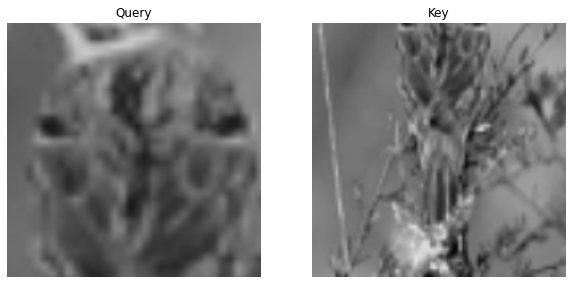

In [13]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

img, label = train_ds[0]

query, key = img[0], img[1]
print('img size: ',query.shape)

# display query and key
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*query+0.5))
plt.title('Query')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*key+0.5))
plt.title('Key')
plt.axis('off')

In [4]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

## 2. Encoder (Query & Key)

`Replacing the output fc projection head with an MLP head`

On top of the usual resnet architecture, we add some dense layers, to get the dimensionality of the representations down to 25

In [5]:
q_encoder = resnet18(pretrained=False)
print('기존 Query encoder :', q_encoder.fc)
print()

# Encoder의 F.C layer 재정의
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(q_encoder.fc.in_features, 100)),
    ('added_relu1', nn.ReLU()),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU()),
    ('fc3', nn.Linear(50, 25))  # 25 차원의 feature를 가짐
]))

q_encoder.fc = classifier
print('재정의된 Query encoder :', q_encoder.fc)

k_encoder = copy.deepcopy(q_encoder)  # Initially, the key encoder has the same parameters as that of the query encoder

q_encoder = q_encoder.to(device)
k_encoder = k_encoder.to(device)

기존 Query encoder : Linear(in_features=512, out_features=1000, bias=True)

재정의된 Query encoder : Sequential(
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (added_relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (added_relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=25, bias=True)
)


In [6]:
summary(q_encoder, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 3. Training

### 3.1 Loss

![image](https://user-images.githubusercontent.com/44194558/154218153-f51d8b4f-0926-4dc8-abb1-b123f4792c2d.png)

In [7]:
def loss_func(q, k, queue, t=0.05):

    N = q.shape[0]  # batch_size
    C = q.shape[1]  # channel(dim)

    # bmm: batch matrix multiplication
    pos = torch.exp(torch.div(torch.bmm(q.view(N, 1, C), k.view(N, C, 1)).view(N, 1), t))  # Nx1
    neg = torch.sum(torch.exp(torch.div(torch.mm(q.view(N, C), torch.t(queue)), t)), dim=1)  # NxK

    # denominator is sum over pos and neg
    denominator = pos + neg  # Nx(K+1)

    return torch.mean(-torch.log(torch.div(pos, denominator)))

In [8]:
opt = optim.Adam(q_encoder.parameters())  # Key encoder는 역전파 x

### 3.2 Initialize Queue

We enqueue the latest batch in our queue. If our queue size gets larger than the maximum queue size that we defined (in K), then we dequeue the oldest batch from it. **Enqueue operation can be done by using torch.cat and dequeue by simply index slicing the tensor.**

In [9]:
# Queue 생성
queue = None
K = 8192  # K: # of negative samples

# Negative sample들의 feature representation을 Queue에 저장
flag = 0
if queue is None:
    while True:
        with torch.no_grad():  # key encoder : 역전파 x
            for img, _ in train_dl:
                # extract key samples
                xk = img[1].to(device)
                k = k_encoder(xk).detach()

                if queue is None:
                    queue = k
                    
                else:
                    if queue.shape[0] < K: # queue < 8192
                        queue = torch.cat((queue, k),0)
                    else:
                        flag = 1 # stop filling the queue

                if flag == 1:
                    break 

        if flag == 1:
            break

queue = queue[:K]

In [10]:
queue.shape  # 각각의 샘플들이 25차원의 feature로 encoding된 상태로 queue에 저장됨

torch.Size([8192, 25])

### 3.3 Train

In [11]:
def Training(q_encoder, k_encoder, num_epochs, queue=queue, loss_func=loss_func, opt=opt, data_dl=train_dl, sanity_check=False):
    loss_history = []
    momentum = 0.999
    start_time = time.time()
    path2weights = './models/q_weights.pt'
    len_data = len(data_dl.dataset)

    q_encoder.train()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))

        q_encoder.train()
        running_loss = 0
        for img, _ in data_dl:
            # retrieve query and key
            xq = img[0].to(device)
            xk = img[1].to(device)

            # get model outputs
            q = q_encoder(xq)
            k = k_encoder(xk).detach()

            # normalize representations
            q = torch.div(q, torch.norm(q, dim=1).reshape(-1, 1))
            k = torch.div(k, torch.norm(k, dim=1).reshape(-1, 1))

            # get loss value
            loss = loss_func(q, k, queue)
            running_loss += loss
            
            # Query encoder에만 역전파 적용
            opt.zero_grad()
            loss.backward()
            opt.step()

            # update the queue
            queue = torch.cat((queue, k), 0)
            if queue.shape[0] > K:
                queue = queue[256:, :]  # 가장 과거의 batch를 dequeue (consistency 유지)
            
            # update k_encoder
            for q_params, k_params in zip(q_encoder.parameters(), k_encoder.parameters()):
                k_params.data.copy_(momentum*k_params + q_params*(1.0-momentum))

        # store loss history
        epoch_loss = running_loss / len(data_dl.dataset)
        loss_history.append(epoch_loss)

        print('train loss: %.6f, time: %.4f min' %(epoch_loss,(time.time()-start_time)/60))

        if sanity_check:
            break

    return q_encoder, k_encoder, loss_history

In [14]:
os.makedirs('./models_MoCoV2', exist_ok=True)

num_epochs = 300
q_encoder, _, loss_history = Training(q_encoder, k_encoder, num_epochs=num_epochs, sanity_check=False)

Epoch 0/299
train loss: 0.030396, time: 0.6018 min
Epoch 1/299
train loss: 0.030768, time: 1.2289 min
Epoch 2/299
train loss: 0.030604, time: 1.8370 min
Epoch 3/299
train loss: 0.031249, time: 2.4454 min
Epoch 4/299
train loss: 0.031772, time: 3.0541 min
Epoch 5/299
train loss: 0.032513, time: 3.6648 min
Epoch 6/299
train loss: 0.032668, time: 4.2805 min
Epoch 7/299
train loss: 0.033307, time: 4.9081 min
Epoch 8/299
train loss: 0.033460, time: 5.5366 min
Epoch 9/299
train loss: 0.033134, time: 6.1732 min
Epoch 10/299
train loss: 0.032867, time: 6.8061 min
Epoch 11/299
train loss: 0.033312, time: 7.4308 min
Epoch 12/299
train loss: 0.033006, time: 8.0581 min
Epoch 13/299
train loss: 0.032733, time: 8.7364 min
Epoch 14/299
train loss: 0.032162, time: 9.4116 min
Epoch 15/299
train loss: 0.032308, time: 10.0862 min
Epoch 16/299
train loss: 0.031864, time: 10.7397 min
Epoch 17/299
train loss: 0.032030, time: 11.4130 min
Epoch 18/299
train loss: 0.031501, time: 12.0766 min
Epoch 19/299
train

In [27]:
losses = [i.cpu().detach().numpy() for i in loss_history]

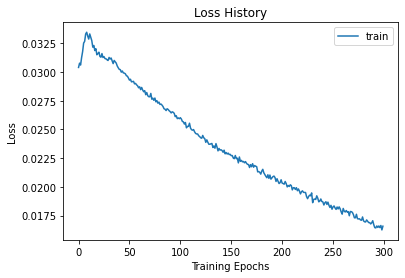

In [26]:
plt.title('Loss History')
plt.plot(losses, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

## 4. Transfer Learning

### 4.1 Data

In [28]:
data_transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [29]:
# load STL-10 dataset
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transform)
val_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transform)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# count the number of images per classes in train_ds
import collections

y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [31]:
# 전이 학습용 transfer_ds가 동일한 class 비율을 갖도록
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

indices = list(range(len(train_ds)))

for _, transfer_index in sss.split(indices, y_train):
    print('transfer_index:', transfer_index[:10])
    print(len(transfer_index))

transfer_index: [4234 1573 1816 3332  504   81 2397 4430 3512 4569]
500


In [32]:
from torch.utils.data import Subset

transfer_ds = Subset(train_ds, transfer_index)  # STL-10 train dataset의 10%로 구성 (500개 이미지)

In [33]:
y_transfer = [y for _, y in transfer_ds]

counter_transfer = collections.Counter(y_transfer)
print(counter_transfer)

Counter({9: 50, 3: 50, 4: 50, 0: 50, 2: 50, 8: 50, 1: 50, 7: 50, 5: 50, 6: 50})


In [34]:
transfer_dl = DataLoader(transfer_ds, 32, True)
val_dl = DataLoader(val_ds, 64, True)

### 4.2 Fine-tuning

In [35]:
# 전이 학습을 위해 q_encoder의 MLP head를 제거하고, Linear layer 추가
if len(nn.Sequential(*list(q_encoder.fc.children()))) == 5:
    q_encoder.fc = nn.Sequential(*list(q_encoder.fc.children())[:-3])

In [36]:
print(*list(q_encoder.fc))

Linear(in_features=512, out_features=100, bias=True) ReLU()


In [37]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.fc1(x)
        return x

linear_classifier = LinearClassifier().to(device)

In [38]:
linear_epoch = 20
linear_loss_func = nn.CrossEntropyLoss()
linear_opt = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)  # q_encoder의 파라미터는 동결, 새로 정의한 linear classifier만 학습

In [39]:
loss_hist = {'train': [], 'val': []}
start_time = time.time()

# start training
for epoch in range(linear_epoch):
    print('Epoch {}/{}'.format(epoch, linear_epoch-1))

    running_train_loss = 0
    running_val_loss = 0
    running_metric = 0

    # transfer dataloader
    linear_classifier.train()  # 새로 추가한 layer만 훈련
    for x, y in transfer_dl:
        x = x.to(device)
        y = y.to(device)

        # extract features using q_encoder
        with torch.no_grad():
            output_encoder = q_encoder(x)  # q_encoder는 위에서 학습한 그대로 사용
        
        linear_opt.zero_grad()   # 새로 추가한 layer의 파라미터만 업데이트
        
        # Fine-tuning용으로 만든 새로운 layer통과
        pred = linear_classifier(output_encoder)
        loss = linear_loss_func(pred, y)

        running_train_loss += loss
        loss.backward()
        linear_opt.step()

    train_loss = running_train_loss / len(transfer_dl.dataset)
    loss_hist['train'].append(train_loss)

    # validation dataloader
    linear_classifier.eval()
    for x, y in val_dl:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output_encoder = q_encoder(x)
            
            pred = linear_classifier(output_encoder)
            loss = linear_loss_func(pred, y)
            
            running_val_loss += loss
            pred = pred.argmax(1, keepdim=True)
            metric = pred.eq(y.view_as(pred)).sum().item()

        running_val_loss += loss    
        running_metric += metric

    val_loss = running_val_loss / len(val_dl.dataset)
    loss_hist['val'].append(val_loss)
    val_metric = running_metric / len(val_dl.dataset) 
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/19
train loss: 1.723507, val loss: 1.145353, accuracy: 28.76, time: 0.1998 min
----------
Epoch 1/19
train loss: 1.406809, val loss: 1.034819, accuracy: 37.56, time: 0.4118 min
----------
Epoch 2/19
train loss: 0.859086, val loss: 0.958743, accuracy: 39.44, time: 0.6179 min
----------
Epoch 3/19
train loss: 0.666000, val loss: 0.705783, accuracy: 39.06, time: 0.8285 min
----------
Epoch 4/19
train loss: 0.778803, val loss: 0.726523, accuracy: 36.44, time: 1.0427 min
----------
Epoch 5/19
train loss: 0.818291, val loss: 0.693539, accuracy: 37.76, time: 1.2521 min
----------
Epoch 6/19
train loss: 0.674635, val loss: 1.095063, accuracy: 32.16, time: 1.4555 min
----------
Epoch 7/19
train loss: 0.644236, val loss: 0.740945, accuracy: 38.82, time: 1.6598 min
----------
Epoch 8/19
train loss: 0.695509, val loss: 0.921615, accuracy: 32.20, time: 1.8634 min
----------
Epoch 9/19
train loss: 0.555528, val loss: 0.558403, accuracy: 39.56, time: 2.0719 min
----------
Epoch 10/19
train lo

In [41]:
losses_train = [i.cpu().detach().numpy() for i in loss_hist['train']]
losses_val = [i.cpu().detach().numpy() for i in loss_hist['val']]

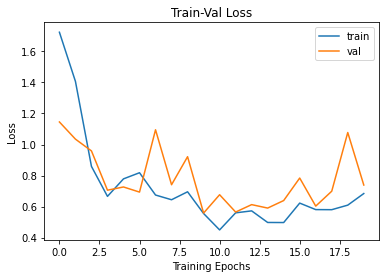

In [44]:
plt.title('Train-Val Loss')
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# q_encoder가 고차원 data로부터 유의미한 latent representation을 제대로 추출하지 못하고 있음

C:\Users\Moon\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


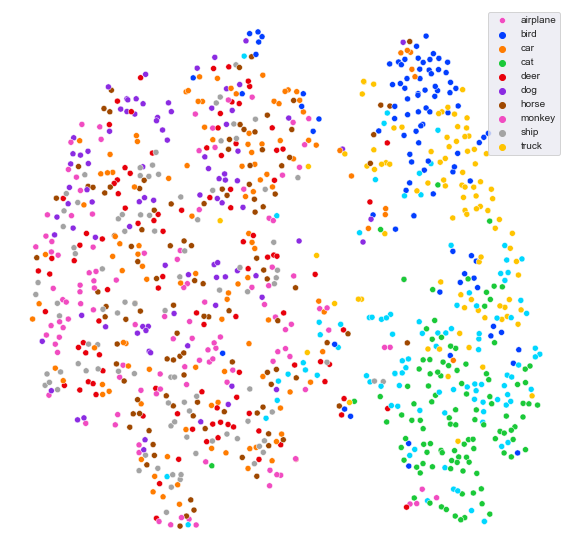

In [46]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE()

def plot_vecs_n_labels(v, labels, fname):
    fig = plt.figure(figsize = (10,10))
    plt.axis('off')
    sns.set_style('darkgrid')
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.legend(['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'])
    plt.savefig(fname)


# change batch_size
val_dl = DataLoader(val_ds, 1024, True)

for x, y in val_dl:
    x = x.to(device)
    with torch.no_grad():
        pred = q_encoder(x)
        pred = linear_classifier(pred)
    pred_tsne = tsne.fit_transform(pred.cpu().data)
    plot_vecs_n_labels(pred_tsne, y, 'tsen.png')
    break